In [2]:
%matplotlib inline

In [152]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize
from scipy import integrate,interpolate
from scipy.linalg import lstsq

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import gsw

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
# from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 4])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [5]:
file = '../data/goship/selected/P01_20070724_00011_00001_ct1.csv'
data = pd.read_csv(file,header=17,skipfooter=1,engine='python')
# data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 8','ML/L'])
data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 9','Unnamed: 10','MG/M^3','UMOL/KG'])
data.rename(columns={'ITS-90':'tmp','PSS-78':'sal','DBAR':'prs'},inplace=True)

In [6]:
lon0 = 146.3
lat0 = 41.9
data['sal'] = gsw.SA_from_SP(data.sal,data.prs,lon0,lat0)
data['tmp'] = gsw.CT_from_t(data.sal,data.tmp,data.prs)
data['rho'] = gsw.rho(data.sal,data.tmp,3000)
data['z'] = gsw.z_from_p(data.prs, lat0)

In [7]:
bins = np.arange(0,6000,2)
data = data.groupby(pd.cut(data.prs,bins)).mean()

In [8]:
ds = pd.DataFrame()
ds['N2'],ds['pmid']= gsw.Nsquared(data.sal,data.tmp,data.prs,lat=40)
ds['z'] = gsw.z_from_p(ds.pmid, lat0)

In [9]:
ds = ds.rolling(window=10,center=True,win_type='hamming').mean()
N0 = np.nanmean( np.sqrt(ds.N2) )
ds['N/N0'] = np.sqrt(ds.N2)/N0

### GO-SHIP full-depth T,S,$\rho$ profiles

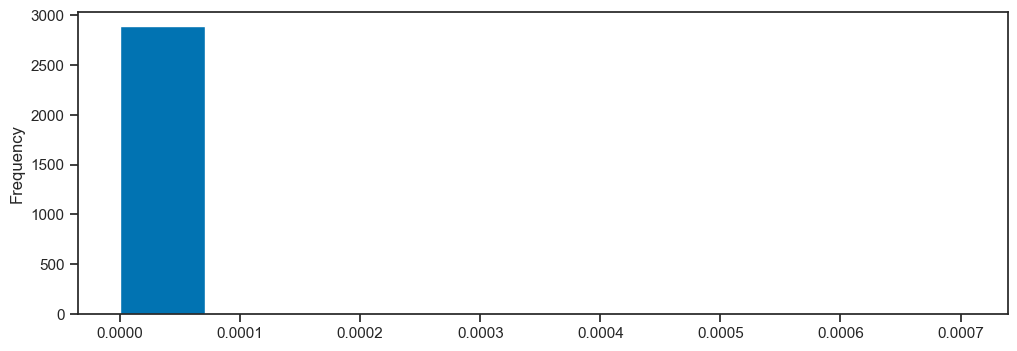

In [184]:
ds.N2.plot.hist()

Text(0.5, 0, 'N/N0')

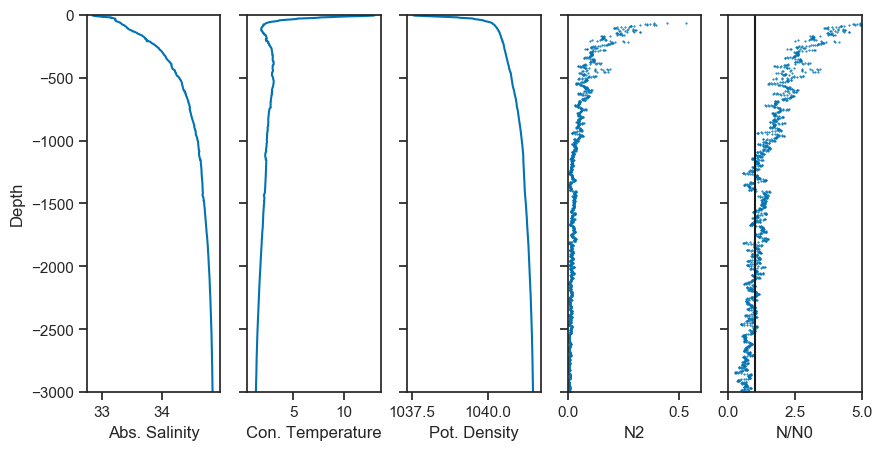

In [186]:
f,ax = plt.subplots(1,5,sharey=True, figsize=(10,5))
ax[0].plot(data.sal,data.z,'-')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Abs. Salinity')
ax[1].plot(data.tmp,data.z,'-')
ax[1].set_xlabel('Con. Temperature')
ax[2].plot(data.rho,data.z,'-')
ax[2].set_xlabel('Pot. Density')

ax[3].plot(ds.N2*1e4,ds.z,'.', markersize=1)
# ax[3].axvline(N0,color='k')
# ax[3].set_xscale('log')
# ax[3].set_xlim(5e-4,1e-2);
ax[3].set_xlabel('N2')
ax[3].set_xlim(0,0.6)
ax[3].set_ylim(-3000,0)

ax[4].plot(ds['N/N0'],ds.z,'.', markersize=1)
ax[4].axvline(N0/N0,color='k')
# ax[4].set_xscale('log')
ax[4].set_xlim(0,5);
ax[4].set_xlabel('N/N0')

# plt.ylim(-1000,0)

### WKB-streched depth z':
$$
z'(z) = \int_0^z \frac{N(z)}{<N>} dz
$$

In [187]:
ds = ds.sort_values('z',ascending=False)
ds = ds.dropna()
zmid = 0.5*( ds.z.values[0:-1] + ds.z.values[1:])
zprime = integrate.cumtrapz(ds['N/N0'],ds['z'])

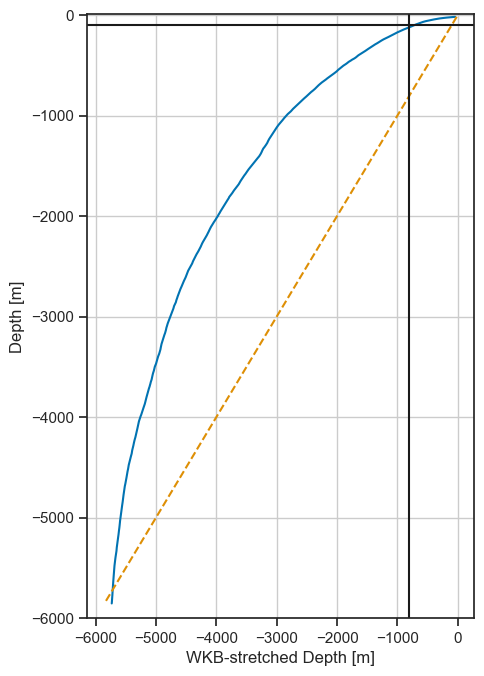

In [161]:
plt.figure(figsize=(5,8))
plt.plot(zprime,zmid)
plt.plot(zmid,zmid,linestyle='dashed')
plt.axhline(-100, color='k')
plt.axvline(-800, color='k')
# plt.annotate('max. z observation',(-6000,-400))
plt.ylabel('Depth [m]')
plt.xlabel("WKB-stretched Depth [m]")
plt.grid()
plt.ylim(-6000,10);

In [158]:
fraction_resolved = -100*1700/ds.z.min()
print(f'Fraction of the water column resolved: {fraction_resolved:2.2f}%')

Fraction of the water column resolved: 29.01%


### Vertical IW modes for N=const

Equation for vertical structure W from ansatz in wave equation:
$$
\frac{d^2W}{dz^2} + k^2 \left( \frac{N^2}{\omega^2} -1 \right)W = 0
$$
with
$$
W = 0,~ z=-D
$$
and
$$
\omega^2\frac{dW}{dz} - gk^2W = 0,~ z=0
$$

In [323]:
D = -ds.z.min()
W = np.zeros((len(zprime),3))
for j in range(1,4):
    W[:,j-1] = np.sin(-j*np.pi*zprime/D)

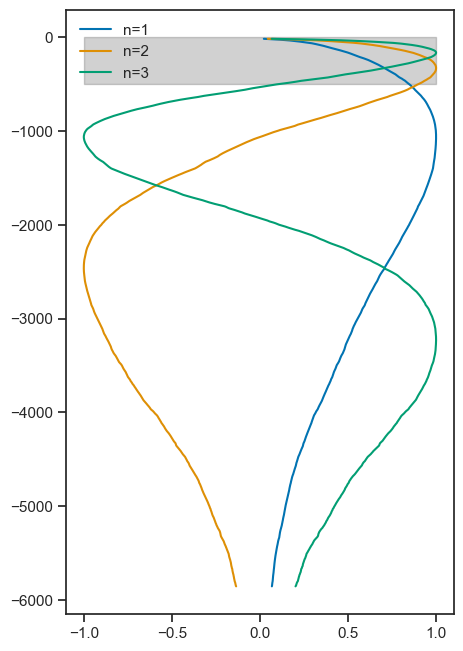

In [324]:
plt.figure(figsize=(5,8))
plt.plot(W,zmid)
plt.legend(labels=['n=1','n=2','n=3','n=4','n=5']);
plt.fill_between([-1,1],y1=-500,y2=0,alpha=0.2, color='k');

# Fit vertical modes to velocity step function

In [325]:
W.shape

(2913, 3)

In [420]:
D = -ds.z.min()
W = np.zeros((len(zprime),20))
for j in range(1,21):
#     W[:,j-1] = np.sin(-j*np.pi*zprime/D) # for vertical velocity 
    W[:,j-1] = j*np.pi*np.cos(-j*np.pi*zprime/D)/D # for vertical velocity 

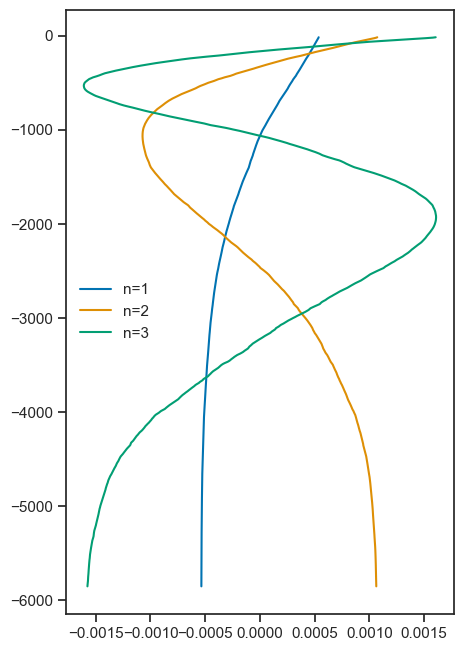

In [421]:
plt.figure(figsize=(5,8))
for i in [0,1,2]:
    plt.plot(W[:,i],zmid)
plt.legend(labels=['n=1','n=2','n=3','n=4','n=5']);
# plt.fill_between([-1,1],y1=-500,y2=0,alpha=0.2, color='k');

In [408]:
raw = xr.open_dataset('../data/raw_temp.nc')

In [409]:
profile1 = raw.isel(time=100)
usurf = profile1.u.where(profile1.z>profile1.mld).mean('z')

In [410]:
step = np.zeros_like(zprime)
step[zprime>-800] = 1

In [411]:
x,res,rank,s =  lstsq(W,step)

In [412]:
from scipy.interpolate import interp1d

In [413]:
ds['wkb'] = np.sqrt(1/ds['N/N0'] )

In [414]:
F = interp1d(ds.z,ds.wkb)
wkb = F(zmid)

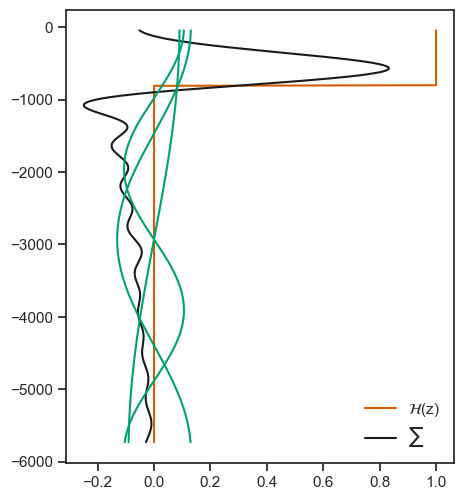

In [415]:
plt.figure(figsize=(5,6))
plt.plot(step,zprime,color='r', label=r'$\mathcal{H}$(z)')
plt.plot(np.dot(W,x),zprime,color='k', label=r'$\sum$')

plt.plot(x[0]*W[:,0],zprime,color='g')
plt.plot(x[1]*W[:,1],zprime,color='g')
plt.plot(x[2]*W[:,2],zprime,color='g')
# plt.plot(x[3]*W[:,3],zprime,color='g')
# plt.plot(x[4]*W[:,4],zprime,color='g')

# plt.ylim(-500,0)
plt.legend()